#**Costa Rican Household Poverty Level Prediction - Kaggle**
###*Can you identify which households have the highest need for social welfare assistance?*
Efraín García Valencia - UdeA

#**1. Importing the DataSet from Kaggle**
###(Note that you will need your own API token from Kaggle)

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"efrangarcavalencia","key":"1b44762b46d8ef3248d00266066caf2d"}'}

In [3]:
#!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c costa-rican-household-poverty-prediction # Download the competition DataSet from Kaggle

  0% 0.00/2.33M [00:00<?, ?B/s]
100% 2.33M/2.33M [00:00<00:00, 200MB/s]


In [5]:
!mkdir DataSet # Create the "DataSet" folder if it doesn't already exist
!unzip -q costa-rican-household-poverty-prediction.zip train.csv test.csv -d DataSet # Unzip only the train.csv and test.csv files into the "DataSet" folder

#**2. Pre-Processing the Data**
### (Data cleaning and visualization)

##2.1 Reading and visualizing the DataSets

### Train and Test preview

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
np.random.seed(seed=217)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [7]:
train = pd.read_csv("/content/DataSet/train.csv")
test = pd.read_csv("/content/DataSet/test.csv")

In [8]:
train

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0000,100.0000,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0000,144.0000,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0000,121.0000,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0000,121.0000,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0000,121.0000,1369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,ID_d45ae367d,80000.0,0,6,0,1,1,0,NaN,0,...,81,2116,25,81,1,1.562500,0.0625,68.0625,2116,2
9553,ID_c94744e07,80000.0,0,6,0,1,1,0,NaN,0,...,0,4,25,81,1,1.562500,0.0625,68.0625,4,2
9554,ID_85fc658f8,80000.0,0,6,0,1,1,0,NaN,0,...,25,2500,25,81,1,1.562500,0.0625,68.0625,2500,2
9555,ID_ced540c61,80000.0,0,6,0,1,1,0,NaN,0,...,121,676,25,81,1,1.562500,0.0625,68.0625,676,2


In [9]:
test

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.2500,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.2500,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.2500,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.0000,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23851,ID_a065a7cad,NaN,1,2,1,1,1,0,NaN,0,...,10,9,100,36,25,4,36.00,0.25,33.0625,100
23852,ID_1a7c6953b,NaN,0,3,0,1,1,0,NaN,0,...,54,36,2916,16,36,4,4.00,1.00,36.0000,2916
23853,ID_07dbb4be2,NaN,0,3,0,1,1,0,NaN,0,...,12,16,144,16,36,4,4.00,1.00,36.0000,144
23854,ID_34d2ed046,NaN,0,3,0,1,1,0,NaN,0,...,12,25,144,16,36,4,4.00,1.00,36.0000,144


In [10]:
train[train.age >= 18].groupby('idhogar').transform("count")

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,0,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
4,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
5,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9551,2,0,2,2,2,2,2,2,0,2,...,2,2,2,2,2,2,2,2,2,2
9552,4,4,4,4,4,4,4,4,0,4,...,4,4,4,4,4,4,4,4,4,4
9554,4,4,4,4,4,4,4,4,0,4,...,4,4,4,4,4,4,4,4,4,4
9555,4,4,4,4,4,4,4,4,0,4,...,4,4,4,4,4,4,4,4,4,4


In [11]:
train_test = train.append(test, ignore_index = True)
train_test

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.00,100.0000,1849,4.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.00,144.0000,4489,4.0
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.00,121.0000,8464,4.0
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.00,121.0000,289,4.0
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.00,121.0000,1369,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33408,ID_a065a7cad,NaN,1,2,1,1,1,0,NaN,0,...,9,100,36,25,4,36.000000,0.25,33.0625,100,NaN
33409,ID_1a7c6953b,NaN,0,3,0,1,1,0,NaN,0,...,36,2916,16,36,4,4.000000,1.00,36.0000,2916,NaN
33410,ID_07dbb4be2,NaN,0,3,0,1,1,0,NaN,0,...,16,144,16,36,4,4.000000,1.00,36.0000,144,NaN
33411,ID_34d2ed046,NaN,0,3,0,1,1,0,NaN,0,...,25,144,16,36,4,4.000000,1.00,36.0000,144,NaN


We can see that our train_test dataframe has 33413 rows and 143 columns

In [12]:
train_test['Id'].value_counts()

ID_279628684    1
ID_6a8161ece    1
ID_c80e9330c    1
ID_0292df9f7    1
ID_f2a1dcdb6    1
               ..
ID_d62b7a353    1
ID_7c223c2db    1
ID_c319051e1    1
ID_4875cf90d    1
ID_34754556f    1
Name: Id, Length: 33413, dtype: int64

Because our dataframe has 33413 different id's and 33413 rows we can say that every id is unique

In [13]:
train_test['idhogar'].value_counts()

9a906088e    13
8e9159699    13
830539cad    13
fd8a6d014    13
ef31faf0f    12
             ..
7fa56c0d9     1
1f0bfdefe     1
c86397adb     1
3b5d0b2a4     1
21eb7fcc1     1
Name: idhogar, Length: 10340, dtype: int64

There are 10340 different households in our dataframe

###Check for one-hot encoded data in our dataset

Are some groups of columns mutually exclusive / one-hot encoded ?


In [14]:
# if so then multiple columns can't be 1 at the same time
# also all the columns should only contain binary data (1 or 0)
def is_mutually_exclusive(dataframe,attributes):
    res_s = dataframe[attributes].sum(axis=1)
    res_s = res_s[res_s > 1]
    if res_s.size == 0:
        print('\033[92m are mutually exclusive \033[97m', attributes)
    else:
        print('\033[91m are not mutually exclusive \033[97m', attributes)

In [15]:
suspected_columns_in_ohe = ['pared', 'piso', 'techo', 'abastagua', 'sanitario',
                            'energ', 'elimbasu','epared', 'etecho', 'eviv',
                            'estadocivil', 'parentesco','instlevel','tipovivi','lugar']
electricity_source = ['public','planpri', 'noelec', 'coopele']
for group_title in suspected_columns_in_ohe:
    group = [col for col in train_test if col.startswith(group_title)]
    is_mutually_exclusive(train_test, group)
is_mutually_exclusive(train_test, electricity_source)

 are mutually exclusive  ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']
 are mutually exclusive  ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']
 are mutually exclusive  ['techozinc', 'techoentrepiso', 'techocane', 'techootro']
 are mutually exclusive  ['abastaguadentro', 'abastaguafuera', 'abastaguano']
 are mutually exclusive  ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']
 are mutually exclusive  ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']
 are mutually exclusive  ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']
 are mutually exclusive  ['epared1', 'epared2', 'epared3']
 are mutually exclusive  ['etecho1', 'etecho2', 'etecho3']
 are mutually exclusive  ['eviv1', 'eviv2', 'eviv3']
 are mutually exclusive  ['estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estado

All of this sets of columns are mutually exclusive, which means we can **label encode** them later on if we are using a decision tree

##2.2 Check for empty / missing data in our dataset

In [16]:
missing = pd.DataFrame(train_test.isnull().sum()).rename(columns={0:'Total'})
missing['Percent']=missing['Total']/len(train_test)
missing.sort_values('Percent',ascending=False).head(10)

,Total,Percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
Target,23856,0.713974
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


We found 4 columns with a high rate of missing data and 2 other columns that seem to have a few of their values missing.

**rez_esc** → *Years behind in school* \\
**v18q1** → *Number of tablets household owns* \\
**v2a1** → *Monthly rent payment* \\
**Target** → *Is our target predictions column* \\
**SBQmeaned** → *Square of the mean years of education of adults (>=18) in the household* \\
**meaneduc** → *Average years of education for adults (18+)* \\

###rez_esc missing values

According to one of the hosts and his replies in the discussions "This variable is only collected for people between 7 and 19 years of age and it is the difference between the years of education a person should have and the years of education he/she has. it is capped at 5."

In [17]:
#set the value of 'rez_esc' to 0 for rows in the 'train_test' DataFrame
#where the 'age' is either greater than 19 or less than 7, and the 'rez_esc' column is null
train_test.loc[((train_test['age']>19) | (train_test['age']<7)) & (train_test['rez_esc'].isnull()), 'rez_esc']=0

In [18]:
missing_rez_esc = train_test[train_test['rez_esc'].isnull() == True]
missing_rez_esc = missing_rez_esc[['rez_esc','age','escolari']]
print(missing_rez_esc.to_string())

       rez_esc  age  escolari
11         NaN   18        12
15         NaN   19        11
17         NaN   19        11
35         NaN   19         0
111        NaN   18         7
144        NaN   18         6
181        NaN   19        11
259        NaN   19        11
272        NaN   19        11
279        NaN   19         7
285        NaN   18         8
289        NaN   18         6
313        NaN   18         9
325        NaN   18         6
376        NaN   19         3
399        NaN   18        11
427        NaN   18        12
456        NaN   19         9
465        NaN   18        11
570        NaN   19        12
600        NaN   18        11
605        NaN   19         6
614        NaN   18        11
621        NaN   18         6
633        NaN   19        11
711        NaN   18         7
725        NaN   18         9
772        NaN   18         7
785        NaN   19        10
801        NaN   18        10
813        NaN   18         8
832        NaN   19         6
836       

Most of the rez_esc that are still missing are of individuals age 18-19, we are going to assume they have already graduated or are not going back to school anymore, in either case rez_esc doesn't apply to them so we are going to fill it as 0

In [19]:
train_test['rez_esc']=train_test['rez_esc'].fillna(0)

In [20]:
over_rez_esc = train_test[train_test['rez_esc'] > 5]
over_rez_esc= over_rez_esc[['rez_esc','age','escolari']]
print(over_rez_esc.to_string())

       rez_esc  age  escolari
13069     99.0    8         0


We check if all rez_esc values meet the condition of beign capped at 5; there seems to be only one individual with an invalid data of 99, assuming that education starts at 7, (age - 7) will give us the years of education a person should have

In [21]:
train_test.loc[train_test['rez_esc'] > 5, 'rez_esc'] = 8 - 7 - 0 # Age - AgeEducationStart - Escolari

Now rez_esc column should be good to go!

### v18q1 missing values

*v18q1* is a column that is heavily related to *v18q*, as *v18q1* is **Number of tablets household owns** and *v18q* is **binary data showing if a household owns a tablet (1 if owned, 0 if not)**

In [22]:
train_test.groupby('v18q')['v18q1'].apply(lambda x:x.isnull().sum())

v18q
0    25468
1        0
Name: v18q1, dtype: int64

All 25468 missing values in 'v18q1' are when 'v18q' equals to 0. meaning that the household doesn't own a tablet which logically means that the number of tablets the household owns is 0 ('v18q1' = 0). Hence, we can fill-in the empty data in 'v18q1' to 0

In [23]:
train_test['v18q1']=train_test['v18q1'].fillna(0)

Now v18q1 column should be good to go!

###v2a1 missing values

According to one of the hosts in the discussions : "In the example of v2a1 you should first filter by tipoviv3. Most households that don't have information will be households that do not rent or are not paying loans (tipoviv2). If a household is tipoviv3 and does not have information then you need to make a choice about the treatment of the variable either assume 0, impute a value or not use the variable. Basically in those cases we don't know the value."

([<matplotlib.axis.XTick at 0x782c2f63d1e0>,
 [Text(0, 0, 'Owns and Paid Off'),
  Text(1, 0, 'Owns and Paying'),
  Text(2, 0, 'Rented'),
  Text(3, 0, 'Precarious'),
  Text(4, 0, 'Other')])

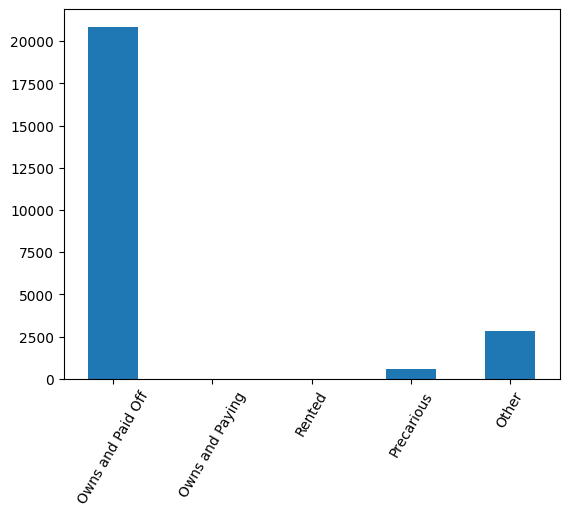

In [24]:
import matplotlib.pyplot as plt
own_variables=[x for x in train_test if x.startswith('tipo')]
train_test.loc[train_test['v2a1'].isnull(),own_variables].sum().plot.bar()
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)

From this graph we can asure that:

* There is **no** empty 'v2a1' when tipovivi2 and tipovivi3 == 1
* Empty 'v2a1' are mostly coming from tipovivi1 which are households that are owned and fully paid off, so they dont need to pay rent

For the other empty values we are going to assume that they also don't need to pay rent


In [25]:
train_test['v2a1']=train_test['v2a1'].fillna(0)

Now v2a1 column should be good to go!

###meaneduc and SBQmeaned missing values

In [26]:
missing_meaneduc = train_test[train_test['meaneduc'].isnull() == True]
missing_meaneduc = missing_meaneduc[['idhogar','age','escolari','meaneduc','SQBmeaned']]
print(missing_meaneduc.to_string())

         idhogar  age  escolari  meaneduc  SQBmeaned
1291   1b31fd159   18        10       NaN        NaN
1840   a874b7ce7   18         6       NaN        NaN
1841   a874b7ce7   18         4       NaN        NaN
2049   faaebf71a   19        12       NaN        NaN
2050   faaebf71a   19        12       NaN        NaN
9561   1e2fc704e   18        11       NaN        NaN
10092  bb7038e41   18        11       NaN        NaN
10093  4937daf94   19        12       NaN        NaN
10094  4937daf94   19        12       NaN        NaN
12169  4deb0c65e   19         8       NaN        NaN
12170  4deb0c65e   17         6       NaN        NaN
16366  74718009d   18        12       NaN        NaN
16367  74718009d   19        12       NaN        NaN
16823  8e4c4b74b   19        12       NaN        NaN
16824  8e4c4b74b   18        10       NaN        NaN
25365  e197a50ea   19         6       NaN        NaN
25366  e197a50ea   18         8       NaN        NaN
25367  e197a50ea    2         0       NaN     

Most of the missing values come from individuals that are between 17-19, maybe they were not adult yet, first let's try to fill in those household with 18+ adults

In [27]:
missing_meaneduc = missing_meaneduc[missing_meaneduc['age']>=18]
missing_meaneduc = missing_meaneduc[['idhogar', 'escolari']]
missing_meaneduc = missing_meaneduc.groupby(by=["idhogar"]).mean()

In [28]:
result = pd.merge(train_test,missing_meaneduc , left_on="idhogar", right_index=True, how="left", sort=False)
result

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,escolari_y
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,...,1849,1,100,0,1.000000,0.00,100.0000,1849,4.0,NaN
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,4489,1,144,0,1.000000,64.00,144.0000,4489,4.0,NaN
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,...,8464,1,0,0,0.250000,64.00,121.0000,8464,4.0,NaN
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,289,16,121,4,1.777778,1.00,121.0000,289,4.0,NaN
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,1369,16,121,4,1.777778,1.00,121.0000,1369,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33408,ID_a065a7cad,0.0,1,2,1,1,1,0,0.0,0,...,100,36,25,4,36.000000,0.25,33.0625,100,NaN,NaN
33409,ID_1a7c6953b,0.0,0,3,0,1,1,0,0.0,0,...,2916,16,36,4,4.000000,1.00,36.0000,2916,NaN,NaN
33410,ID_07dbb4be2,0.0,0,3,0,1,1,0,0.0,0,...,144,16,36,4,4.000000,1.00,36.0000,144,NaN,NaN
33411,ID_34d2ed046,0.0,0,3,0,1,1,0,0.0,0,...,144,16,36,4,4.000000,1.00,36.0000,144,NaN,NaN


In [29]:
result['meaneduc']=result['meaneduc'].fillna(result['escolari_y'])

Check if there are still some missing values

In [30]:
missing_meaneduc_result = result[result['meaneduc'].isnull() == True]
missing_meaneduc_result = missing_meaneduc_result[['idhogar','age','escolari_x','meaneduc','SQBmeaned']]
print(missing_meaneduc_result.to_string())

         idhogar  age  escolari_x  meaneduc  SQBmeaned
25848  c31f9f3a0   17           9       NaN        NaN
31201  c49af2e64   17           9       NaN        NaN
31202  c49af2e64    1           0       NaN        NaN


there seems to be 2 households that don't have any adults, We are going to fill in their 'meaneduc' with 0

In [31]:
result['meaneduc']=result['meaneduc'].fillna(0)

In [32]:
result['SQBmeaned']=result['SQBmeaned'].fillna(result['meaneduc']*result['meaneduc'])

In [33]:
missing_meaneduc_result = result[result['SQBmeaned'].isnull() == True]
missing_meaneduc_result = missing_meaneduc_result[['idhogar','age','escolari_x','meaneduc','SQBmeaned']]
print(missing_meaneduc_result.to_string())

Empty DataFrame
Columns: [idhogar, age, escolari_x, meaneduc, SQBmeaned]
Index: []


In [34]:
train_test['meaneduc'] = result['meaneduc']
train_test['SQBmeaned'] = result['SQBmeaned']

Now meaneduc and SBQmeaned columns should be good to go!

###We check again for any missing values that may still exist

In [35]:
missing = pd.DataFrame(train_test.isnull().sum()).rename(columns={0:'total'})
missing['Percent']=missing['total']/len(train_test)
missing.sort_values('Percent',ascending=False).head(10)

,total,Percent
Target,23856,0.713974
hogar_mayor,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000
idhogar,0,0.000000
hogar_nin,0,0.000000
hogar_adul,0,0.000000
hogar_total,0,0.000000
parentesco8,0,0.000000


There are no longer any missing values of importance (Target having missing values is expected and normal)

##2.3 Check for dataType inconsistencies in our dataset

In [36]:
print(train_test.dtypes.to_string())

Id                  object
v2a1               float64
hacdor               int64
rooms                int64
hacapo               int64
v14a                 int64
refrig               int64
v18q                 int64
v18q1              float64
r4h1                 int64
r4h2                 int64
r4h3                 int64
r4m1                 int64
r4m2                 int64
r4m3                 int64
r4t1                 int64
r4t2                 int64
r4t3                 int64
tamhog               int64
tamviv               int64
escolari             int64
rez_esc            float64
hhsize               int64
paredblolad          int64
paredzocalo          int64
paredpreb            int64
pareddes             int64
paredmad             int64
paredzinc            int64
paredfibras          int64
paredother           int64
pisomoscer           int64
pisocemento          int64
pisoother            int64
pisonatur            int64
pisonotiene          int64
pisomadera           int64
t

In [37]:
train_test.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


We found inconsistencies with the data in 3 different columns:
* **dependency** → *Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)*
* **edjefe** → *Years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0*
* **edjefa** → *Years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0*

from the data we can gather that when the head of household is a male, 'edjefe' will be a number value whereas 'edjefa' will be a 'no' and when the head of household is a female, 'edjefa' will be a number value whereas 'edjefe' will be a 'no'

From this we can get that a "yes" = 1 and a "no" = 0 and replace those values acordingly so that the columns are fully numerical

In [38]:
mapping_dict={'yes':1,"no":0}
train_test['dependency'] = train_test['dependency'].replace(mapping_dict).astype(np.float64)
train_test['edjefe'] = train_test['edjefe'].replace(mapping_dict).astype("int")
train_test['edjefa'] = train_test['edjefa'].replace(mapping_dict).astype("int")
train_test['edjef'] = np.max(train_test[['edjefa','edjefe']], axis=1)

In [39]:
print(train_test.dtypes.to_string())

Id                  object
v2a1               float64
hacdor               int64
rooms                int64
hacapo               int64
v14a                 int64
refrig               int64
v18q                 int64
v18q1              float64
r4h1                 int64
r4h2                 int64
r4h3                 int64
r4m1                 int64
r4m2                 int64
r4m3                 int64
r4t1                 int64
r4t2                 int64
r4t3                 int64
tamhog               int64
tamviv               int64
escolari             int64
rez_esc            float64
hhsize               int64
paredblolad          int64
paredzocalo          int64
paredpreb            int64
pareddes             int64
paredmad             int64
paredzinc            int64
paredfibras          int64
paredother           int64
pisomoscer           int64
pisocemento          int64
pisoother            int64
pisonatur            int64
pisonotiene          int64
pisomadera           int64
t

In [40]:
train_test.select_dtypes('object').head()

,Id,idhogar
0,ID_279628684,21eb7fcc1
1,ID_f29eb3ddd,0e5d7a658
2,ID_68de51c94,2c7317ea8
3,ID_d671db89c,2b58d945f
4,ID_d56d6f5f5,2b58d945f


Now we don't have inconsistent data in our columns (ids are supposed to be a mix of numbers and letters so it's fine)

In [41]:
# convert to int if float but only has integer value
train_test['v18q1'] = train_test['v18q1'].astype("int")
train_test['rez_esc'] = train_test['rez_esc'].astype("int")

Lastly we are casting some float types that aren't supposed to be there to int type, and with that our pre-processing is complete, we can now start with the exploratory data analysis of our dataset

#**3. Processing the Data**
###(EDA and feature extraction)

In [42]:
from sklearn.preprocessing import LabelEncoder
def do_features(df):
    df['idhogar'] = LabelEncoder().fit_transform(df['idhogar'])
    feats_div = [('children_fraction', 'r4t1', 'r4t3'),
                 ('working_man_fraction', 'r4h2', 'r4t3'),
                 ('all_man_fraction', 'r4h3', 'r4t3'),
                 ('human_density', 'tamviv', 'rooms'),
                 ('human_bed_density', 'tamviv', 'bedrooms'),
                 ('rent_per_person', 'v2a1', 'r4t3'),
                 ('rent_per_room', 'v2a1', 'rooms'),
                 ('mobile_density', 'qmobilephone', 'r4t3'),
                 ('tablet_density', 'v18q1', 'r4t3'),
                 ('mobile_adult_density', 'qmobilephone', 'r4t2'),
                 ('tablet_adult_density', 'v18q1', 'r4t2'),
                ]

    feats_sub = [('people_not_living', 'tamhog', 'tamviv'),
                 ('people_weird_stat', 'tamhog', 'r4t3')]

    for f_new, f1, f2 in feats_div:
        df['fe_' + f_new] = (df[f1] / df[f2]).astype(np.float32)
    for f_new, f1, f2 in feats_sub:
        df['fe_' + f_new] = (df[f1] - df[f2]).astype(np.float32)

    # aggregation rules over household
    aggs_num = {'age': ['min', 'max', 'mean'],
                'escolari': ['min', 'max', 'mean']
               }

    aggs_cat = {'dis': ['mean']}
    for s_ in ['estadocivil', 'parentesco', 'instlevel']:
        for f_ in [f_ for f_ in df.columns if f_.startswith(s_)]:
            aggs_cat[f_] = ['mean', 'count']

    # aggregation over household
    for name_, df_ in [('18', df.query('age >= 18'))]:
        df_agg = df_.groupby('idhogar').agg({**aggs_num, **aggs_cat}).astype(np.float32)
        df_agg.columns = pd.Index(['agg' + name_ + '_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
        df = df.join(df_agg, how='left', on='idhogar')
        del df_agg

    # Drop id's
    #df.drop(['Id'], axis=1, inplace=True)

    return df
train_test = do_features(train_test)

In [43]:
# convert one hot encoded fields to label encoding
from sklearn.preprocessing import LabelEncoder
def convert_OHE2LE(df):
    tmp_df = df.copy(deep=True)
    for s_ in ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 'energcocinar', 'elimbasu',
               'epared', 'etecho', 'eviv', 'estadocivil', 'parentesco',
               'instlevel', 'lugar', 'tipovivi',
               'manual_elec']:
        if 'manual_' not in s_:
            cols_s_ = [f_ for f_ in df.columns if f_.startswith(s_)]
        elif 'elec' in s_:
            cols_s_ = ['public', 'planpri', 'noelec', 'coopele'] #do for electricity also
        sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
        #deal with those OHE, where there is a sum over columns == 0
        if 0 in sum_ohe:
            print('The OHE in {} is incomplete. A new column will be added before label encoding'
                  .format(s_))
            # dummy colmn name to be added
            col_dummy = s_+'_dummy'
            # add the column to the dataframe
            tmp_df[col_dummy] = (tmp_df[cols_s_].sum(axis=1) == 0).astype(np.int8)
            # add the name to the list of columns to be label-encoded
            cols_s_.append(col_dummy)
            # proof-check, that now the category is complete
            sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
            if 0 in sum_ohe:
                 print("The category completion did not work")
        tmp_cat = tmp_df[cols_s_].idxmax(axis=1)
        tmp_df[s_ + '_LE'] = LabelEncoder().fit_transform(tmp_cat).astype(np.int16)
        if 'parentesco1' in cols_s_:
            cols_s_.remove('parentesco1')
        tmp_df.drop(cols_s_, axis=1, inplace=True)
    return tmp_df
train_test = convert_OHE2LE(train_test)

The OHE in techo is incomplete. A new column will be added before label encoding
The OHE in instlevel is incomplete. A new column will be added before label encoding
The OHE in manual_elec is incomplete. A new column will be added before label encoding


In [44]:
def convert_geo2aggs(df_):
    cols_2_ohe = ['eviv_LE', 'etecho_LE', 'epared_LE', 'elimbasu_LE',
              'energcocinar_LE', 'sanitario_LE', 'manual_elec_LE',
              'pared_LE']
    cols_nums = ['age', 'meaneduc', 'dependency',
                 'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
                 'bedrooms', 'overcrowding']

    tmp_df = pd.concat([df_[(['lugar_LE', 'idhogar']+cols_nums)],
                        pd.get_dummies(df_[cols_2_ohe],
                                       columns=cols_2_ohe)],axis=1)

    geo_agg = tmp_df.groupby(['lugar_LE','idhogar']).mean().groupby('lugar_LE').mean().astype(np.float32)
    geo_agg.columns = pd.Index(['geo_' + e for e in geo_agg.columns.tolist()])

    del tmp_df
    return df_.join(geo_agg, how='left', on='lugar_LE')

# add some aggregates by geography
train_test = convert_geo2aggs(train_test)

In [45]:
train_test

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,geo_manual_elec_LE_3,geo_manual_elec_LE_4,geo_pared_LE_0,geo_pared_LE_1,geo_pared_LE_2,geo_pared_LE_3,geo_pared_LE_4,geo_pared_LE_5,geo_pared_LE_6,geo_pared_LE_7
0,ID_279628684,190000.0,0,3,0,1,1,0,0,0,...,0.000500,0.951460,0.67256,0.007173,0.001668,0.084737,0.001501,0.168307,0.014512,0.049541
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1,0,...,0.000500,0.951460,0.67256,0.007173,0.001668,0.084737,0.001501,0.168307,0.014512,0.049541
2,ID_68de51c94,0.0,0,8,0,1,1,0,0,0,...,0.000500,0.951460,0.67256,0.007173,0.001668,0.084737,0.001501,0.168307,0.014512,0.049541
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1,0,...,0.000500,0.951460,0.67256,0.007173,0.001668,0.084737,0.001501,0.168307,0.014512,0.049541
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1,0,...,0.000500,0.951460,0.67256,0.007173,0.001668,0.084737,0.001501,0.168307,0.014512,0.049541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33408,ID_a065a7cad,0.0,1,2,1,1,1,0,0,0,...,0.001263,0.434343,0.44697,0.007576,0.003788,0.217172,0.000000,0.188131,0.003788,0.132576
33409,ID_1a7c6953b,0.0,0,3,0,1,1,0,0,0,...,0.001263,0.434343,0.44697,0.007576,0.003788,0.217172,0.000000,0.188131,0.003788,0.132576
33410,ID_07dbb4be2,0.0,0,3,0,1,1,0,0,0,...,0.001263,0.434343,0.44697,0.007576,0.003788,0.217172,0.000000,0.188131,0.003788,0.132576
33411,ID_34d2ed046,0.0,0,3,0,1,1,0,0,0,...,0.001263,0.434343,0.44697,0.007576,0.003788,0.217172,0.000000,0.188131,0.003788,0.132576


In [46]:
train_test['num_over_18'] = 0
train_test['num_over_18'] = train_test.groupby('idhogar')['age'].transform('size')
train_test['num_over_18'] = train_test.groupby("idhogar")["num_over_18"].transform("max")
train_test['num_over_18'] = train_test['num_over_18'].fillna(0)
# add some extra features, these were taken from another kernel
def extract_features(df):
    # add the number of people over 18 in each household
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms'] # tamhog - size of the household
    df['r4t3_to_tamhog'] = df['r4t3']/df['tamhog'] # r4t3 - Total persons in the household
    df['r4t3_to_rooms'] = df['r4t3']/df['rooms'] # r4t3 - Total persons in the household
    df['v2a1_to_r4t3'] = df['v2a1']/df['r4t3'] # rent to people in household
    df['v2a1_to_r4t3'] = df['v2a1']/(df['r4t3'] - df['r4t1']) # rent to people under age 12
    df['hhsize_to_rooms'] = df['hhsize']/df['rooms'] # rooms per person
    df['rent_to_hhsize'] = df['v2a1']/df['hhsize'] # rent to household size
    df['rent_to_over_18'] = df['v2a1']/df['num_over_18']
    # some households have no one over 18, use the total rent for those
    df.loc[df.num_over_18 == 0, "rent_to_over_18"] = df[df.num_over_18 == 0].v2a1

extract_features(train_test)

In [47]:
train_test

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,num_over_18,bedrooms_to_rooms,rent_to_rooms,tamhog_to_rooms,r4t3_to_tamhog,r4t3_to_rooms,v2a1_to_r4t3,hhsize_to_rooms,rent_to_hhsize,rent_to_over_18
0,ID_279628684,190000.0,0,3,0,1,1,0,0,0,...,1,0.333333,63333.333333,0.333333,1.0,0.333333,190000.0,0.333333,190000.0,190000.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1,0,...,1,0.250000,33750.000000,0.250000,1.0,0.250000,135000.0,0.250000,135000.0,135000.0
2,ID_68de51c94,0.0,0,8,0,1,1,0,0,0,...,1,0.250000,0.000000,0.125000,1.0,0.125000,0.0,0.125000,0.0,0.0
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1,0,...,4,0.600000,36000.000000,0.800000,1.0,0.800000,60000.0,0.800000,45000.0,45000.0
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1,0,...,4,0.600000,36000.000000,0.800000,1.0,0.800000,60000.0,0.800000,45000.0,45000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33408,ID_a065a7cad,0.0,1,2,1,1,1,0,0,0,...,6,0.500000,0.000000,3.000000,1.0,3.000000,0.0,3.000000,0.0,0.0
33409,ID_1a7c6953b,0.0,0,3,0,1,1,0,0,0,...,4,0.666667,0.000000,1.333333,1.0,1.333333,0.0,1.333333,0.0,0.0
33410,ID_07dbb4be2,0.0,0,3,0,1,1,0,0,0,...,4,0.666667,0.000000,1.333333,1.0,1.333333,0.0,1.333333,0.0,0.0
33411,ID_34d2ed046,0.0,0,3,0,1,1,0,0,0,...,4,0.666667,0.000000,1.333333,1.0,1.333333,0.0,1.333333,0.0,0.0


In [48]:
# drop duplicated columns
needless_cols = ['r4t3', 'tamhog', 'tamviv', 'hhsize', 'v18q', 'v14a', 'agesq',
                 'mobilephone', 'female', ]

#instlevel_cols = [s for s in train.columns.tolist() if 'instlevel' in s]

#needless_cols.extend(instlevel_cols)

train_test = train_test.drop(needless_cols, axis=1)

In [49]:
test_final = train_test.loc[train_test["Target"].isnull()]
test_final = test_final.drop(['Target'], axis=1)
test_final = test_final.fillna(0)
test_final.to_csv(r'test_final_v1.csv', index = False)
test_final

,Id,v2a1,hacdor,rooms,hacapo,refrig,v18q1,r4h1,r4h2,r4h3,...,num_over_18,bedrooms_to_rooms,rent_to_rooms,tamhog_to_rooms,r4t3_to_tamhog,r4t3_to_rooms,v2a1_to_r4t3,hhsize_to_rooms,rent_to_hhsize,rent_to_over_18
9557,ID_2f6873615,0.0,0,5,0,1,0,1,1,2,...,3,0.400000,0.0,0.600000,1.0,0.600000,0.0,0.600000,0.0,0.0
9558,ID_1c78846d2,0.0,0,5,0,1,0,1,1,2,...,3,0.400000,0.0,0.600000,1.0,0.600000,0.0,0.600000,0.0,0.0
9559,ID_e5442cf6a,0.0,0,5,0,1,0,1,1,2,...,3,0.400000,0.0,0.600000,1.0,0.600000,0.0,0.600000,0.0,0.0
9560,ID_a8db26a79,0.0,0,14,0,1,1,0,1,1,...,1,0.071429,0.0,0.071429,1.0,0.071429,0.0,0.071429,0.0,0.0
9561,ID_a62966799,175000.0,0,4,0,1,1,0,0,0,...,1,0.500000,43750.0,0.250000,1.0,0.250000,175000.0,0.250000,175000.0,175000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33408,ID_a065a7cad,0.0,1,2,1,1,0,0,2,2,...,6,0.500000,0.0,3.000000,1.0,3.000000,0.0,3.000000,0.0,0.0
33409,ID_1a7c6953b,0.0,0,3,0,1,0,0,1,1,...,4,0.666667,0.0,1.333333,1.0,1.333333,0.0,1.333333,0.0,0.0
33410,ID_07dbb4be2,0.0,0,3,0,1,0,0,1,1,...,4,0.666667,0.0,1.333333,1.0,1.333333,0.0,1.333333,0.0,0.0
33411,ID_34d2ed046,0.0,0,3,0,1,0,0,1,1,...,4,0.666667,0.0,1.333333,1.0,1.333333,0.0,1.333333,0.0,0.0


In [50]:
train_final = train_test.loc[train_test["Target"].notnull()]
train_final = train_final.fillna(0)
train_final.to_csv(r'train_final_v1.csv', index = False)
train_final

,Id,v2a1,hacdor,rooms,hacapo,refrig,v18q1,r4h1,r4h2,r4h3,...,num_over_18,bedrooms_to_rooms,rent_to_rooms,tamhog_to_rooms,r4t3_to_tamhog,r4t3_to_rooms,v2a1_to_r4t3,hhsize_to_rooms,rent_to_hhsize,rent_to_over_18
0,ID_279628684,190000.0,0,3,0,1,0,0,1,1,...,1,0.333333,63333.333333,0.333333,1.0,0.333333,190000.0,0.333333,190000.0,190000.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,0,1,1,...,1,0.250000,33750.000000,0.250000,1.0,0.250000,135000.0,0.250000,135000.0,135000.0
2,ID_68de51c94,0.0,0,8,0,1,0,0,0,0,...,1,0.250000,0.000000,0.125000,1.0,0.125000,0.0,0.125000,0.0,0.0
3,ID_d671db89c,180000.0,0,5,0,1,1,0,2,2,...,4,0.600000,36000.000000,0.800000,1.0,0.800000,60000.0,0.800000,45000.0,45000.0
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,0,2,2,...,4,0.600000,36000.000000,0.800000,1.0,0.800000,60000.0,0.800000,45000.0,45000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,ID_d45ae367d,80000.0,0,6,0,1,0,0,2,2,...,5,0.666667,13333.333333,0.833333,1.0,0.833333,20000.0,0.833333,16000.0,16000.0
9553,ID_c94744e07,80000.0,0,6,0,1,0,0,2,2,...,5,0.666667,13333.333333,0.833333,1.0,0.833333,20000.0,0.833333,16000.0,16000.0
9554,ID_85fc658f8,80000.0,0,6,0,1,0,0,2,2,...,5,0.666667,13333.333333,0.833333,1.0,0.833333,20000.0,0.833333,16000.0,16000.0
9555,ID_ced540c61,80000.0,0,6,0,1,0,0,2,2,...,5,0.666667,13333.333333,0.833333,1.0,0.833333,20000.0,0.833333,16000.0,16000.0


In [51]:
cols_with_missing = [col for col in train_final.columns
                                 if train_final[col].isnull().any()]
cols_with_missing

[]

In [52]:
train_final.loc[train_final['agg18_estadocivil1_MEAN'].isnull()]

,Id,v2a1,hacdor,rooms,hacapo,refrig,v18q1,r4h1,r4h2,r4h3,...,num_over_18,bedrooms_to_rooms,rent_to_rooms,tamhog_to_rooms,r4t3_to_tamhog,r4t3_to_rooms,v2a1_to_r4t3,hhsize_to_rooms,rent_to_hhsize,rent_to_over_18


In [53]:
train_test.to_csv(r'train_test.csv', index = False)

In [54]:
# train_test = pd.read_csv("../input/costa-rica/train_test.csv") # check for cleanliness Version 14

train = train_test.loc[~train_test['Target'].isnull()]
test = train_test.loc[train_test['Target'].isnull()]

test = test.drop(['Target'], axis=1)

original_test = pd.read_csv("/content/DataSet/test.csv")

test_ids = original_test.Id

In [55]:
# Need test id when exporting prediction result
# test_ids = test.Id

# But Id and idhogar are not needed during model building
train.drop(columns = ["Id", "idhogar"], inplace = True)
test.drop(columns = ["Id", "idhogar"], inplace = True)

train_length = train.shape[0]
test_length = test.shape[0]

In [56]:
# Our subjects of interest are heads of household
# Hence, for training, we will only be using these subjects

# But for test data, we have to predict for both heads and non-heads,
# except that results for non-heads are not graded.
# Hence, we treat all the test data like heads of household for prediction purposes.

X = train[train.parentesco1 == 1].copy()
y = X['Target'] - 1
y = y.astype('int')
X.drop(['Target', "parentesco1"], axis=1, inplace = True)

test.drop(columns = ["parentesco1"], inplace = True)

#**4. Processing the Data**
### (Features selection and model training)

In [73]:
# Since our training data is so imbalanced, we shall not allocate the same weight to all target classes
# Instead, target classes that are more "rare" shall get higher weight
# y_train_weights = class_weight.compute_sample_weight('balanced', y_train, indices=None)
y_weights = class_weight.compute_sample_weight('balanced', y, indices=None)

# Let's take a look
# Indeed, target class 1, which is the rarest, gets the highest weight
# Then weight decreases as the Target class becomes more common
# print(pd.DataFrame(dict(Target = y_train+1, Weight = y_train_weights)).drop_duplicates().sort_values(by = ["Target"]).reset_index(drop = True))
print(pd.DataFrame(dict(Target = y, Weight = y_weights)).drop_duplicates().sort_values(by = ["Target"]).reset_index(drop = True))

   Target    Weight
0       0  3.347973
1       1  1.681561
2       2  2.093662
3       3  0.380374


In [74]:
def split_data(train, y, sample_weight=None, test_percentage=0.20):
    # pick some random households to use for the test data
    test_idx = np.random.choice(train.index, size = int(train.shape[0] * test_percentage), replace = False)

    X_test = train.loc[test_idx]
    y_test = y.loc[test_idx]

    X_train = train.loc[~train.index.isin(test_idx)]
    y_train = y.loc[~train.index.isin(test_idx)]

    if sample_weight is not None:
        y_train_weights = sample_weight[~train.index.isin(test_idx)]
        return X_train, y_train, X_test, y_test, y_train_weights

    return X_train, y_train, X_test, y_test

In [75]:
train_X, train_y, val_X, val_y, train_y_weights = split_data(X, y, y_weights, test_percentage = 0.30)

In [76]:
def evaluate_macroF1_xgb(predictions, truth):
    pred_labels = predictions.reshape(4,-1).argmax(axis=0)
    truth = truth.get_label()
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1)

xgb_fit_params={"early_stopping_rounds":500,
                "eval_metric" : evaluate_macroF1_xgb,
                'verbose': False,
               }

xgb_ = xgb.XGBClassifier(random_state=217, n_jobs=-1)
xgb_fit_params["eval_set"] = [(val_X,val_y)]
model = xgb_.fit(train_X, train_y, sample_weight = train_y_weights, **xgb_fit_params)
useless_xgb_cols = train_X.columns[model.feature_importances_ == 0].tolist()

In [77]:
rf_ = RandomForestClassifier(random_state=217, n_jobs=-1)
rf_.fit(X, y)
useless_rf_cols = X.columns[rf_.feature_importances_ == 0].tolist()

In [78]:
def evaluate_macroF1_lgb(truth, predictions):
    pred_labels = predictions.reshape(4,-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True)

lgb_fit_params={
                "eval_metric" : evaluate_macroF1_lgb,

               }

lgb_fit_params["eval_set"] = [(val_X,val_y)]
lgb_ = lgb.LGBMClassifier(random_state = 217, n_jobs=-1,early_stopping_rounds=500,verbose= 0,)
model = lgb_.fit(train_X, train_y, sample_weight = train_y_weights, **lgb_fit_params)
useless_lgb_cols = X.columns[model.feature_importances_ == 0].tolist()

[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


In [79]:
print("XGBClassifier eliminated {} features".format(len(useless_xgb_cols)))
print("RandomForestClassifier eliminated {} features".format(len(useless_rf_cols)))
print("LGBMClassifier eliminated {} features".format(len(useless_lgb_cols)))

XGBClassifier eliminated 80 features
RandomForestClassifier eliminated 3 features
LGBMClassifier eliminated 71 features


In [80]:
xgb_opt_parameters = {'n_estimators':300, 'learning_rate':0.15, 'max_depth':35, 'eta':0.15,
                      'objective':'multi:softmax', 'min_child_weight': 2, 'num_class': 4, 'gamma': 2.5,
                      'colsample_bylevel': 1, 'subsample': 0.95, 'colsample_bytree': 0.85, 'reg_lambda': 0.35 }

rf_opt_parameters = {"max_depth": None, "n_estimators": 500, "min_impurity_decrease": 1e-3,
                    "min_samples_leaf": 2, "class_weight": "balanced"}

lgb_opt_parameters = {'max_depth':45, "learning_rate":0.15, 'objective':'multiclass', 'silent':True, #'metric':evaluate_macroF1_lgb,
                      'n_estimators':300, 'class_weight':'balanced','colsample_bytree': 0.89, 'min_child_samples':90,
                      'num_leaves':20, 'subsample':0.96}

In [81]:
''' xgbs = []
for i in range(0, 16):
    xgb_ = xgb.XGBClassifier(random_state=217+i, n_jobs=-1, **xgb_opt_parameters)
    train_X, train_y, val_X, val_y, train_y_weights = split_data(X.drop(columns = useless_xgb_cols), y, sample_weight= y_weights)
    xgb_fit_params["eval_set"] = [(val_X,val_y)]
    xgb_.fit(train_X, train_y, sample_weight = train_y_weights, **xgb_fit_params)
    xgbs.append(xgb_) '''

rfs = []
for i in range(0, 8):
    rf = RandomForestClassifier(random_state=217+i, n_jobs=-1, **rf_opt_parameters)
    rf.fit(X.drop(useless_rf_cols, axis=1), y)
    rfs.append(rf)

lgbs = []
for i in range(0, 9):
    lgb_ = lgb.LGBMClassifier(random_state=217+i, n_jobs=-1, **lgb_opt_parameters)
    train_X, train_y, val_X, val_y  = split_data(X.drop(columns = useless_lgb_cols), y)
    lgb_fit_params["eval_set"] = [(val_X,val_y)]
    lgb_.fit(train_X, train_y, **lgb_fit_params)
    lgbs.append(lgb_)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2127
[LightGBM] [Info] Number of data points in the train set: 2379, number of used features: 111
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [82]:
''' xgb_predictions_hard_test = []
for i in range(0, len(xgbs)):
    xgb_predictions_hard_test.append(xgbs[i].predict(test.drop(columns = useless_xgb_cols ).fillna(0))) '''

rf_predictions_hard_test = []
for i in range(0, len(rfs)):
    rf_predictions_hard_test.append(rfs[i].predict(test.drop(columns = useless_rf_cols ).fillna(0)))

lgb_predictions_hard_test = []
for i in range(0, len(lgbs)):
    lgb_predictions_hard_test.append(lgbs[i].predict(test.drop(columns = useless_lgb_cols).fillna(0)))

''' xgb_predictions_soft_test = []
for i in range(0, len(xgbs)):
    xgb_predictions_soft_test.append(xgbs[i].predict_proba(test.drop(columns = useless_xgb_cols ).fillna(0))) '''

rf_predictions_soft_test = []
for i in range(0, len(rfs)):
    rf_predictions_soft_test.append(rfs[i].predict_proba(test.drop(columns = useless_rf_cols ).fillna(0)))

lgb_predictions_soft_test = []
for i in range(0, len(lgbs)):
    lgb_predictions_soft_test.append(lgbs[i].predict_proba(test.drop(columns = useless_lgb_cols ).fillna(0)))

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent


In [83]:
def generate_results(settings):
    #num_of_xgbs = settings[0]
    num_of_rfs = settings[1]
    num_of_lgbs = settings[2]
    voting_type = settings[3]

    if voting_type == "Hard":
        all_predictions = []
        ''' if len(xgb_predictions_hard_test[0:num_of_xgbs]) != 0:
            all_predictions.extend(xgb_predictions_hard_test[0:num_of_xgbs]) '''
        if len(rf_predictions_hard_test[0:num_of_rfs]) != 0:
            all_predictions.extend(rf_predictions_hard_test[0:num_of_rfs])
        if len(lgb_predictions_hard_test[0:num_of_lgbs]) != 0:
            all_predictions.extend(lgb_predictions_hard_test[0:num_of_lgbs])
        combined_predictions = np.vstack(all_predictions).transpose()
        combined_predictions = pd.DataFrame(combined_predictions).mode(axis = 1)
        combined_predictions = combined_predictions.median(axis = 1).astype('int')

    if voting_type == "Soft":
        ''' xgbs_predictions = sum(xgb_predictions_soft_test[0:num_of_xgbs]) '''
        rfs_predictions = sum(rf_predictions_soft_test[0:num_of_rfs])
        lgbs_predictions = sum(lgb_predictions_soft_test[0:num_of_lgbs])
        combined_predictions = sum([rfs_predictions, lgbs_predictions])
        combined_predictions = combined_predictions.argmax(axis = 1)

    return combined_predictions

In [84]:
results = generate_results((7, 8, 9, 'Hard'))

In [85]:
submission = pd.DataFrame(test_ids)
submission["Target"] = results + 1
submission.to_csv("submission.csv", index = False)

In [86]:
results

0        3
1        3
2        3
3        3
4        3
        ..
23851    2
23852    1
23853    1
23854    1
23855    1
Length: 23856, dtype: int64